# calc_factors

In [1]:
%load_ext autoreload
%autoreload 2

In [304]:
import logging

import pandas as pd
import numpy as np
import os
from typing import Union, List
from datetime import datetime, time, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pickle
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from copy import deepcopy
from collections import defaultdict

from backtest.preprocessors.preprocess import LobTimePreprocessor, LobFeatureEngineering
from backtest.predefined.macros import LobColTemplate, ColTemplate, CITICSF_ColTemplate
from backtest.statistic_tools.statistics import calc_r_squared
from backtest.utils import get_class_name, get_expire_map, calc_date2maturity, calc_time2maturity, calc_effective_price, \
    calc_iv_greeks,plot_legend_outside

root = '/Users/hongyifan/Desktop/work/internship/citic_futures/20231226bid-ask-spread/'
data_root = root + 'data/'
option_data_root = root + 'data/Option/'
future_data_root = root + 'data/Future/'
etf_data_root = root + 'data/ETF/'
res_root = root + 'res/'
model_root = root + 'models/'

etf_future_symbol_dict = {
    '510050.XSHG': 'IH',
    '510300.XSHG': 'IF',
    '510500.XSHG': 'IC',

}

trading_dates = np.array(
    pd.read_csv(data_root + f'trading_dates_cn_2000-01-01_2024-12-31.csv')['trading_dates'].tolist(), dtype=str)

ltp = LobTimePreprocessor()



# 循环遍历所有合约


In [3]:
# etf价格
etf_price_dict = {}
for udly_symbol in ['510050.XSHG', '510300.XSHG', '510500.XSHG']:
    etf_price_dict[udly_symbol] = \
        pd.read_csv(data_root + "ETF/" + f"data_etf_{udly_symbol}_2014-12-01_2023-11-28.csv",
                    usecols=['datetime', 'close'],
                    index_col='datetime', parse_dates=True)['close'].rename('etf_price_' + udly_symbol)

In [4]:
# 无风险利率采用1年期国债收益率
def get_rfr(interest_rate_df, date_, days2maturity):
    idx = np.argmin(abs(interest_rate_df.columns - days2maturity))
    return interest_rate_df.loc[date_].iloc[idx]


interest_rate = pd.read_csv(data_root + f"interest_rate.csv", index_col=0).rename(columns={'ON': 1,  # over night
                                                                                           '1W': 5,
                                                                                           '2W': 10,
                                                                                           '1M': 20,
                                                                                           '3M': 60,
                                                                                           '6M': 120,
                                                                                           '9M': 180,
                                                                                           '1Y': 240}) / 100

In [5]:
# 获取所有日期
dates_list = os.listdir(option_data_root)
dates_list.remove('.DS_Store')
dates_list = sorted(dates_list)
dates_list = pd.to_datetime(dates_list, format='%Y-%m-%d').astype(str).tolist()

In [ ]:

option_info_df = pd.read_csv(data_root + 'etf_options_basic_info.csv')
option_info_df['code'] = option_info_df['code'].apply(lambda x: x[:-5])
option_info_df = option_info_df.set_index('code').sort_index()
expire_date_list = sorted(option_info_df['expire_date'].unique())

In [ ]:
train_start = '2023-08-17'
train_end = '2023-09-27'
valid_start = ''
valid_end = ''
test_start = valid_start
test_end = valid_end

In [406]:
def get_sibling_option_trading_code(option_trading_code):
    if option_trading_code[6] == 'C':
        option_trading_code1 = option_trading_code.replace('C', 'P')
    elif option_trading_code[6] == 'P':
        option_trading_code1 = option_trading_code.replace('P', 'C')
    else:
        raise ValueError()
    return option_trading_code1


def read_option_pair_prices(date_, option_symbol, option_symbol1):
    # 第一个期权
    option_price_df = pd.read_csv(option_data_root + date_.replace('-', '') + '/' + f'{option_symbol}.csv',
                                  parse_dates=True, index_col='serverTime')
    option_price_df = option_price_df.loc[~option_price_df['auctionLabel']]
    option_price_df = ltp.del_untrade_time(option_price_df, cut_tail=False)

    # 对应期权
    option_price_df1 = pd.read_csv(option_data_root + date_.replace('-', '') + '/' + f'{option_symbol1}.csv',
                                   parse_dates=True, index_col='serverTime')
    option_price_df1 = option_price_df1.loc[~option_price_df1['auctionLabel']]
    option_price_df1 = ltp.del_untrade_time(option_price_df1, cut_tail=False)

    option_price_dict = {}
    if option_type == 'CO':
        option_price_dict['c'] = option_price_df
        option_price_dict['p'] = option_price_df1
    else:
        option_price_dict['p'] = option_price_df
        option_price_dict['c'] = option_price_df1
    return option_price_dict


def synthesize_future(option_price_dict, method, level, etf_price_df, fe: LobFeatureEngineering):
    eff_price_dict = {}
    eff_price_dict['c'] = calc_effective_price(fe, option_price_dict['c'], method=method,
                                               level=level).sort_index().rename('eff_price_c')
    eff_price_dict['p'] = calc_effective_price(fe, option_price_dict['p'], method=method,
                                               level=level).sort_index().rename('eff_price_p')

    pcp_df = pd.concat([eff_price_dict['c'], eff_price_dict['p'],
                        option_price_dict['c'].loc[:, ['ask1', 'bid1']].rename(
                            columns={'ask1': 'ask1_c', 'bid1': 'bid1_c'}),
                        option_price_dict['p'].loc[:, ['ask1', 'bid1']].rename(
                            columns={'ask1': 'ask1_p', 'bid1': 'bid1_p'}),
                        ], axis=1).sort_index().ffill().dropna(how='any', axis=0)

    pcp_df = pd.concat([pcp_df, etf_price_df], axis=1).sort_index().ffill().dropna(how='any', axis=0,
                                                                                   subset=etf_price_df.name)
    pcp_df.index = pd.to_datetime(pcp_df.index)

    expiry = pd.to_datetime([date_ + ' 15:00:00.000000'] * len(pcp_df))

    # pcp
    current = pcp_df.index
    time2maturity = calc_time2maturity(current=current, expiry=expiry, days2maturity=days2maturity, annualized=240)

    pcp_df = pd.concat([pcp_df, time2maturity], axis=1)
    pcp_df['syn_price_effective'] = (
            pcp_df['eff_price_c'] + option_strike * np.exp(-pcp_df['time2maturity'] * rfr) - pcp_df[
        'eff_price_p']).rename('syn_price_effective')
    pcp_df['syn_price_bid'] = (
            pcp_df['bid1_c'] + option_strike * np.exp(-pcp_df['time2maturity'] * rfr) - pcp_df['ask1_p']).rename(
        'syn_price_bid')
    pcp_df['syn_price_ask'] = (
            pcp_df['ask1_c'] + option_strike * np.exp(-pcp_df['time2maturity'] * rfr) - pcp_df['bid1_p']).rename(
        'syn_price_ask')
    pcp_df['syn_price_mid'] = ((pcp_df['syn_price_ask'] + pcp_df['syn_price_bid']) / 2).rename('syn_price_mid')
    pcp_df['spread_syn'] = pcp_df['syn_price_ask'] - pcp_df['syn_price_bid']
    pcp_df['spread_c'] = pcp_df['ask1_c'] - pcp_df['bid1_c']
    pcp_df['spread_p'] = pcp_df['ask1_p'] - pcp_df['bid1_p']
    pcp_df.index = pd.to_datetime(pcp_df.index)
    return pcp_df


def calc_syn_all_spread(date_, option_info_df, expire_date, udly_symbol, etf_price_df, fe, method='cum_vol_wap',
                        level=2):
    """通过所有同mat但是不同strike的call和put去计算syn_bid and syn_ask，再分别取最大和最小值来计算每个时刻的syn_all_spread
    
    Parameters
    ----------
    date_ : 
    option_info_df : 
    expire_date : 
    udly_symbol : 
    etf_price_df : 
    fe : 
    method : 
    level : 

    Returns
    -------

    """
    idx = np.logical_and(option_info_df['expire_date'] == expire_date,
                         option_info_df['underlying_symbol'] == udly_symbol)

    syn_all_price_ask = pd.DataFrame()
    syn_all_price_bid = pd.DataFrame()
    for k, v in option_info_df.loc[idx].sort_values(['contract_type', 'exercise_price']).groupby('exercise_price',
                                                                                                 as_index=False):
        # print(v.index)
        option_symbol, option_symbol1 = v.index.values
        try:
            assert option_symbol + '.csv' in files
            assert option_symbol1 + '.csv' in files
        except AssertionError:
            print(f"pair not in file list {option_symbol, option_symbol1}")
            continue
        option_price_dict = read_option_pair_prices(date_, option_symbol, option_symbol1)
        pcp_df = synthesize_future(option_price_dict, method, level, etf_price_df, fe)[
            ['syn_price_ask', 'syn_price_bid']].rename(
            columns={'syn_price_ask': f'syn_price_ask_{k}', 'syn_price_bid': f'syn_price_bid_{k}'})
        syn_all_price_ask = pd.concat([syn_all_price_ask, pcp_df[f'syn_price_ask_{k}']], axis=1)
        syn_all_price_bid = pd.concat([syn_all_price_bid, pcp_df[f'syn_price_bid_{k}']], axis=1)

    syn_all_price_ask = syn_all_price_ask.sort_index().ffill()
    syn_all_price_bid = syn_all_price_bid.sort_index().ffill()

    syn_all_ask_min = syn_all_price_ask.min(axis=1).rename('syn_all_ask_min')
    syn_all_bid_max = syn_all_price_bid.max(axis=1).rename('syn_all_bid_max')
    syn_all_spread = (syn_all_ask_min - syn_all_bid_max).rename('syn_all_spread')
    distribution = syn_all_spread.describe()
    lower = distribution['mean'] - 2 * distribution['std']
    upper = distribution['mean'] + 2 * distribution['std']
    syn_all_spread[np.logical_or(syn_all_spread < lower, syn_all_spread > upper)] = np.nan

    return syn_all_spread


def calc_duration(temp, name='avg_duration'):
    origin_index = temp.index
    is_afternoon = temp.index.time.astype(str) >= '13:00:00'
    temp.index = np.where(is_afternoon, temp.index - timedelta(hours=1, minutes=30), temp.index)
    duration = (temp.index[1:] - temp.index[:-1]).total_seconds().astype(float).to_series(index=origin_index[1:],
                                                                                          name=name)
    return duration


def is_opening_period(index: pd.DatetimeIndex):
    index_str = index.time.astype(str)
    idx = index_str < '09:30:30'
    idx1 = np.logical_and(index_str > '13:00:00', index_str < '13:00:10')
    # idx2=index_str>'14:56:30'
    idx = np.logical_or(idx, idx1)
    # idx=np.logical_or(idx,idx2)
    return idx

def calc_all_factors():

    # static_factors
    moneyness = (pcp_df['syn_price_mid'] * np.exp(rfr * pcp_df['time2maturity']) / option_strike).rename('moneyness')
    moneyness = np.log(moneyness)  # 使其分布更加正态
    moneyness_squared = (moneyness ** 2).rename('moneyness_squared')
    moneyness_t2m = (moneyness * pcp_df['time2maturity']).rename('moneyness_t2m')
    moneyness_delta = (moneyness * iv_greeks['delta']).rename('moneyness_delta')
    mid_quoted_price = ((option_price_df['ask1'] + option_price_df['bid1']) / 2).rename('mid_quoted_price')
    
    syn_spread = pcp_df['spread_syn']
    static_factors = pd.concat(
        [moneyness, moneyness_squared, moneyness_t2m, moneyness_delta, mid_quoted_price, pcp_df['time2maturity'],
         syn_spread], axis=1)
    static_factors = ltp.del_untrade_time(static_factors)
    
    # dynamic_factors
    option_price_df['volume_diff'] = option_price_df['volume'].diff()
    option_price_df.loc[option_price_df.index[0], 'volume_diff'] = option_price_df['volume'].iloc[0]
    
    window_size = 10
    dynamic_factors = option_price_df['volume_diff'].loc[~(option_price_df['volume_diff'] == 0)].to_frame(
        name='avg_volume_diff')
    dynamic_factors = pd.concat([dynamic_factors, calc_duration(deepcopy(dynamic_factors), name='avg_duration')], axis=1)
    dynamic_factors = dynamic_factors.rolling(window_size, min_periods=1).mean()
    dynamic_factors = ltp.del_untrade_time(dynamic_factors)
    
    
    
    # cross_market_factors
    # percentage spread of underlying asset (ETF) ETF百分比价差
    etf_price_df = pd.read_csv(f"{etf_data_root}/{date_1}/{udly_symbol[:-5]}.csv", index_col='serverTime',
                               usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
    etf_quoted_spread = (
            2 * (etf_price_df['ask1'] - etf_price_df['bid1']) / (etf_price_df['ask1'] + etf_price_df['bid1'])).rename(
        'etf_quoted_spread')
    # plot_legend_outside(etf_quoted_spread,shrink=1000,plot_uniform_timestamp=True)
    # percentage spread of index futures 股指期货百分比价差
    future_price_df = pd.read_csv(f"{future_data_root}{date_1}/{etf_future_symbol_dict[udly_symbol]}{expire_date1}.csv",
                                  index_col='serverTime', usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
    future_quoted_spread = (2 * (future_price_df['ask1'] - future_price_df['bid1']) / (
            future_price_df['ask1'] + future_price_df['bid1'])).rename('future_quoted_spread')
    # plot_legend_outside(future_quoted_spread,shrink=1000,plot_uniform_timestamp=True)
    
    cross_market_factors = pd.concat([etf_quoted_spread, future_quoted_spread], axis=1)
    cross_market_factors.index = pd.to_datetime(cross_market_factors.index)
    cross_market_factors = ltp.del_untrade_time(cross_market_factors)
        
        
    # dummies
    dummies = pd.DataFrame()
    dummies['is_opening_period'] = pd.Series(is_opening_period(pcp_df.index), index=pcp_df.index, name='is_opening_period',
                                             dtype=int)
    
    
    # 开盘不久，spread会快速下降，此时主要是time2maturity在变，因此或许该阶段time2maturity需要有较大的coef。是否可以通过dummy来构造这个
    opening_decreasing = (
            np.log(1.001 - pcp_df['time2maturity'] / pcp_df['time2maturity'][0]) * dummies['is_opening_period']).rename(
        'opening_decreasing')
    # plot_legend_outside(opening_decreasing, shrink=1000, plot_uniform_timestamp=True)
    
    # 拼接数据
    # y_col = 'percentage_spread'
    y_col = 'spread'
    Xy = pd.concat(
        [iv_greeks, syn_all_spread, static_factors, dynamic_factors, cross_market_factors, dummies, opening_decreasing,
         # percentage_spread,
         spread
         ], axis=1)
    Xy.index = pd.to_datetime(Xy.index)
    Xy = Xy.sort_index().ffill()
    
    dropna_cols = Xy.columns.tolist()
    dropna_cols.remove('avg_volume_diff')
    dropna_cols.remove('avg_duration')
    Xy = ltp.del_untrade_time(Xy).dropna(how='any', subset=dropna_cols)
    Xy = ltp.add_head_tail(Xy, date_=date_)
    Xy = ltp.del_untrade_time(Xy.asfreq('3s', method='ffill')).dropna(how='any')
    
    # delete outliers
    Xy_mean = Xy.mean()
    Xy_std = Xy.std()
    idx = ((Xy - Xy_mean) / Xy_std).abs() > 3
    exclude = ['delta', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'avg_duration', 'is_opening_period',
               'opening_decreasing']
    idx = idx.drop(columns=exclude)
    idx = idx.sum(axis=1).astype(bool)
    
    # todo归一化
    Xy = Xy.loc[~idx]
    
    return Xy

In [322]:
# 遍历所有csv计算factors
fe = LobFeatureEngineering(curr='last', ColFormatter=CITICSF_ColTemplate)
Xy_dict = defaultdict(dict)
print("option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘")
rfr = 0.03
exclude = ['510050.csv', '510300.csv', '510500.csv']
for date_ in dates_list[:1]:
    # date_ = '2023-08-01'
    date_1 = date_.replace('-', '')
    files = []
    expire_date_map = get_expire_map(date_=date_, expire_date_list=expire_date_list)
    Xy_dict_today = {}
    for r, _, f in os.walk(option_data_root + date_.replace('-', '') + '/'):
        for ff in f:
            # 去掉中证1000股指期权
            if not ff.startswith('.') and ff not in exclude and not ff.startswith('MO'):
                files.append(ff)
    option_symbol_list = [s[:-4] for s in files]
    option_symbol_list_bkp = deepcopy(option_symbol_list)

    for option_symbol in option_symbol_list_bkp:
        # option_symbol = '10005684'
        # option_symbol = '10005679'

        # 判断与预处理
        if option_symbol not in option_symbol_list:
            logging.warning("option_symbol not in option_symbol_list")
            continue
        option_trading_code, expire_date, option_type, option_strike, option_underlying_symbol = option_info_df.loc[
            option_symbol, ['trading_code', 'expire_date', 'contract_type', 'exercise_price',
                            'underlying_symbol']].values
        expire_date1 = expire_date.replace('-', '')[2:6]
        flag = option_type.lower()[0]
        option_expire_type = expire_date_map[expire_date]  # 当月下月当季下季的四个mat合约
        # 寻找相同mat和strike的对应期权
        option_trading_code1 = get_sibling_option_trading_code(option_trading_code)
        option_symbol1 = option_info_df.loc[option_info_df['trading_code'] == option_trading_code1].index.values[0]
        assert option_symbol1 + '.csv' in files
        # etf现货价格
        etf_price_df = \
            pd.read_csv(etf_data_root + date_1 + '/' + option_underlying_symbol[:-5] + '.csv',
                        usecols=['serverTime', 'last'],
                        index_col='serverTime', parse_dates=True)['last'].rename('etf_price').replace(0, np.nan)
        print(date_, option_trading_code)
        
        # 基础参数
        days2maturity = calc_date2maturity(current=date_, expiry=expire_date, trading_dates=trading_dates)  # 计算有多少天到期
        rfr = get_rfr(interest_rate_df=interest_rate, date_=date_, days2maturity=days2maturity)  # risk-free rate
        option_price_dict = read_option_pair_prices(date_, option_symbol, option_symbol1)
        option_price_df = option_price_dict[flag]
        
        # y
        spread = (option_price_df['ask1'] - option_price_df['bid1']).rename('spread')
        # percentage_spread = (2 * (option_price_df['ask1'] - option_price_df['bid1']) / (
        #         option_price_df['ask1'] + option_price_df['bid1'])).rename('percentage_spread')

        # =========== 计算factors ==========
        # 通过wap计算期权有效价格
        method = 'cum_vol_wap'
        level = 2
        pcp_df = synthesize_future(option_price_dict=option_price_dict, method=method, level=level,
                                   etf_price_df=etf_price_df,
                                   fe=fe)

        # iv greeks
        iv_greeks = calc_iv_greeks(price=pcp_df[f'eff_price_{flag}'],
                                   # S=pcp_df['etf_price'],
                                   # S=pcp_df['syn_price_effective'],
                                   S=pcp_df['syn_price_mid'],  # 一般用合成期货价格，因为etf无法做空
                                   K=option_strike,
                                   t=pcp_df['time2maturity'],
                                   r=rfr, flag=flag, q=0,
                                   calc_greeks=True,
                                   index=pcp_df.index).dropna(how='all')

        # 合成期货套利空间因子
        syn_all_spread = calc_syn_all_spread(date_, option_info_df, expire_date, udly_symbol, etf_price_df, fe,
                                             method=method, level=level)        
            
        # static_factors
        moneyness = (pcp_df['syn_price_mid'] * np.exp(rfr * pcp_df['time2maturity']) / option_strike).rename('moneyness')
        moneyness = np.log(moneyness)  # 使其分布更加正态
        moneyness_squared = (moneyness ** 2).rename('moneyness_squared')
        moneyness_t2m = (moneyness * pcp_df['time2maturity']).rename('moneyness_t2m')
        moneyness_delta = (moneyness * iv_greeks['delta']).rename('moneyness_delta')
        mid_quoted_price = ((option_price_df['ask1'] + option_price_df['bid1']) / 2).rename('mid_quoted_price')
        
        syn_spread = pcp_df['spread_syn']
        static_factors = pd.concat(
            [moneyness, moneyness_squared, moneyness_t2m, moneyness_delta, mid_quoted_price, pcp_df['time2maturity'],
             syn_spread], axis=1)
        static_factors = ltp.del_untrade_time(static_factors)
        
        # dynamic_factors
        option_price_df['volume_diff'] = option_price_df['volume'].diff()
        option_price_df.loc[option_price_df.index[0], 'volume_diff'] = option_price_df['volume'].iloc[0]
        
        window_size = 10
        dynamic_factors = option_price_df['volume_diff'].loc[~(option_price_df['volume_diff'] == 0)].to_frame(
            name='avg_volume_diff')
        dynamic_factors = pd.concat([dynamic_factors, calc_duration(deepcopy(dynamic_factors), name='avg_duration')], axis=1)
        dynamic_factors = dynamic_factors.rolling(window_size, min_periods=1).mean()
        dynamic_factors = ltp.del_untrade_time(dynamic_factors)
        
        
        # cross_market_factors
        # percentage spread of underlying asset (ETF) ETF百分比价差
        etf_price_df = pd.read_csv(f"{etf_data_root}/{date_1}/{udly_symbol[:-5]}.csv", index_col='serverTime',
                                   usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
        etf_quoted_spread = (
                2 * (etf_price_df['ask1'] - etf_price_df['bid1']) / (etf_price_df['ask1'] + etf_price_df['bid1'])).rename(
            'etf_quoted_spread')
        # plot_legend_outside(etf_quoted_spread,shrink=1000,plot_uniform_timestamp=True)
        # percentage spread of index futures 股指期货百分比价差
        future_price_df = pd.read_csv(f"{future_data_root}{date_1}/{etf_future_symbol_dict[udly_symbol]}{expire_date1}.csv",
                                      index_col='serverTime', usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
        future_quoted_spread = (2 * (future_price_df['ask1'] - future_price_df['bid1']) / (
                future_price_df['ask1'] + future_price_df['bid1'])).rename('future_quoted_spread')
        # plot_legend_outside(future_quoted_spread,shrink=1000,plot_uniform_timestamp=True)
        
        cross_market_factors = pd.concat([etf_quoted_spread, future_quoted_spread], axis=1)
        cross_market_factors.index = pd.to_datetime(cross_market_factors.index)
        cross_market_factors = ltp.del_untrade_time(cross_market_factors)
            
        # dummies
        dummies = pd.DataFrame()
        dummies['is_opening_period'] = pd.Series(is_opening_period(pcp_df.index), index=pcp_df.index, name='is_opening_period',
                                                 dtype=int)
        
        # 开盘不久，spread会快速下降，此时主要是time2maturity在变，因此或许该阶段time2maturity需要有较大的coef。是否可以通过dummy来构造这个
        opening_decreasing = (
                np.log(1.001 - pcp_df['time2maturity'] / pcp_df['time2maturity'][0]) * dummies['is_opening_period']).rename(
            'opening_decreasing')
        # plot_legend_outside(opening_decreasing, shrink=1000, plot_uniform_timestamp=True)
        
        # 拼接数据
        # y_col = 'percentage_spread'
        y_col = 'spread'
        Xy = pd.concat(
            [iv_greeks, syn_all_spread, static_factors, dynamic_factors, cross_market_factors, dummies, opening_decreasing,
             # percentage_spread,
             spread
             ], axis=1)
        Xy.index = pd.to_datetime(Xy.index)
        Xy = Xy.sort_index().ffill()
        
        dropna_cols = Xy.columns.tolist()
        dropna_cols.remove('avg_volume_diff')
        dropna_cols.remove('avg_duration')
        Xy = ltp.del_untrade_time(Xy).dropna(how='any', subset=dropna_cols)
        Xy = ltp.add_head_tail(Xy, date_=date_)
        Xy = ltp.del_untrade_time(Xy.asfreq('3s', method='ffill')).dropna(how='any')
        
        # delete outliers
        Xy_mean = Xy.mean()
        Xy_std = Xy.std()
        idx = ((Xy - Xy_mean) / Xy_std).abs() > 3
        exclude = []
        # exclude = ['delta', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'avg_duration', 'is_opening_period',
        #            'opening_decreasing']
        idx = idx.drop(columns=exclude)
        idx = idx.sum(axis=1).astype(bool)
        
        # todo归一化
        Xy = Xy.loc[~idx]
        
        Xy_dict_today[(option_trading_code, option_expire_type, option_type, option_strike)] = Xy
    Xy_dict[date_] = Xy_dict_today
    break


option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘
/Users/hongyifan/Desktop/work/internship/citic_futures/20231226bid-ask-spread/data/Option/20230801/


# 计算factors


In [324]:
print(date_, date_1, option_symbol)

2023-08-01 20230801 10005684


## 寻找对应期权

In [325]:
# main
option_trading_code, expire_date, option_type, option_strike, option_underlying_symbol = option_info_df.loc[
    option_symbol, ['trading_code', 'expire_date', 'contract_type', 'exercise_price', 'underlying_symbol']].values
expire_date1 = expire_date.replace('-', '')[2:6]
days2maturity = calc_date2maturity(current=date_, expiry=expire_date, trading_dates=trading_dates)  # 计算有多少天到期

# 寻找相同mat和strike的对应期权
option_trading_code1 = get_sibling_option_trading_code(option_trading_code)
option_symbol1 = option_info_df.loc[option_info_df['trading_code'] == option_trading_code1].index.values[0]
assert option_symbol1 + '.csv' in files

option_price_dict = read_option_pair_prices(date_, option_symbol, option_symbol1)
option_price_df = option_price_dict['c']
option_price_df1 = option_price_dict['p']

In [388]:
# etf现货价格
etf_price_df = \
    pd.read_csv(etf_data_root + date_1 + '/' + option_underlying_symbol[:-5] + '.csv', usecols=['serverTime', 'last'],
                index_col='serverTime', parse_dates=True)['last'].rename('etf_price').replace(0, np.nan)

In [327]:
# 当天股指期货价格
# future_list=os.listdir(future_data_root+date_1+'/')
# future_filename=etf_future_symbol_dict[option_underlying_symbol]+expire_date.replace('-','')[2:6]+".csv"
# future_price=pd.read_csv(future_data_root+date_1+"/"+future_filename,index_col='serverTime')
# future_price

In [331]:
option_info_df.loc[[option_symbol, option_symbol1]]

,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_price,...,list_price,high_limit,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason
code,,,,,,,,,,,,,,,,,,,,,
10005684,510500C2308M06250,500ETF购8月6250,CO,XSHG,CNY,510500.XSHG,南方中证500ETF,XSHG,ETF,6.25,...,0.0468,0.628,0.0001,2023-08-23,2023-08-23,2023-08-23,2023-08-24,0,2023-08-24,合约到期
10005693,510500P2308M06250,500ETF沽8月6250,PO,XSHG,CNY,510500.XSHG,南方中证500ETF,XSHG,ETF,6.25,...,0.2539,0.857,0.0001,2023-08-23,2023-08-23,2023-08-23,2023-08-24,0,2023-08-24,合约到期


## 合成期货

In [401]:
# 通过wap计算期权有效价格

fe = LobFeatureEngineering(curr='last', ColFormatter=CITICSF_ColTemplate)

# method='wap'
# level=1
method = 'cum_vol_wap'
level = 2

pcp_df = synthesize_future(option_price_dict=option_price_dict, method=method, level=level, etf_price_df=etf_price_df,
                           fe=fe)

                              wap1_c
2023-08-01 09:30:00.478367  0.069555
2023-08-01 09:30:01.008075  0.069555
2023-08-01 09:30:01.564205  0.068789
2023-08-01 09:30:02.123419  0.068836
2023-08-01 09:30:02.694800  0.070273
...                              ...
2023-08-01 14:56:57.422464  0.066750
2023-08-01 14:56:57.926925  0.066950
2023-08-01 14:56:58.428939  0.066800
2023-08-01 14:56:58.940136  0.066880
2023-08-01 14:56:59.425248  0.066700

[28332 rows x 1 columns]


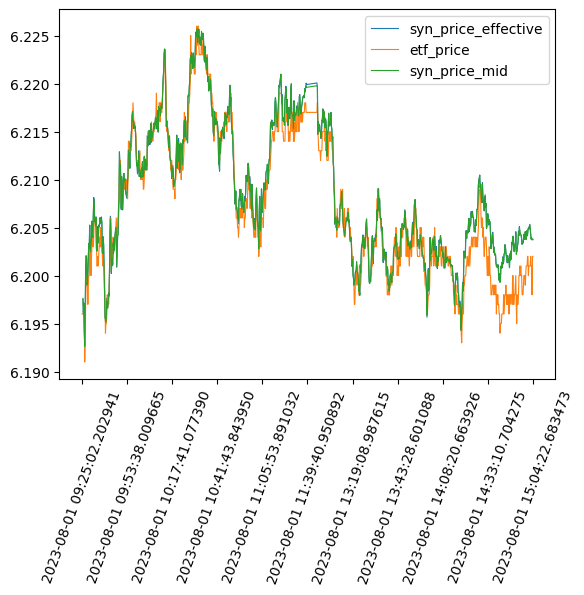

In [333]:
# 一般来说，spread和价格涨跌存在较为明显的正相关
plot_legend_outside(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']], shrink=1000,
                    plot_uniform_timestamp=True)
# 恒成立
# plot_legend_outside(pcp_df[['spread_syn','spread_c','spread_p']], shrink=1000, plot_uniform_timestamp=True)
# pcp_df['spread_syn']==pcp_df['spread_c']-pcp_df['spread_p']

## 计算iv和greeks

In [334]:

flag = 'p'
iv_greeks = calc_iv_greeks(price=pcp_df[f'eff_price_{flag}'],
                           # S=pcp_df['etf_price'],
                           # S=pcp_df['syn_price_effective'],
                           S=pcp_df['syn_price_mid'],  # 一般用合成期货价格，因为etf无法做空
                           K=option_strike,
                           t=pcp_df['time2maturity'],
                           r=rfr, flag=flag, q=0,
                           calc_greeks=True,
                           index=pcp_df.index)
iv_greeks.dropna(how='all')

,IV,delta,gamma,vega,theta,rho
serverTime,,,,,,
2023-08-01 09:30:00.478367,0.137661,-0.574202,1.779391,0.006272,-0.001611,-0.002447
2023-08-01 09:30:01.008075,0.137661,-0.574202,1.779391,0.006272,-0.001611,-0.002447
2023-08-01 09:30:01.101018,0.139354,-0.573141,1.758660,0.006275,-0.001634,-0.002444
2023-08-01 09:30:01.564205,0.138989,-0.574073,1.762621,0.006272,-0.001628,-0.002448
2023-08-01 09:30:01.564221,0.143566,-0.582703,1.700849,0.006238,-0.001675,-0.002485
...,...,...,...,...,...,...
2023-08-01 15:04:43.682103,0.136872,-0.566336,1.854127,0.006097,-0.001673,-0.002259
2023-08-01 15:04:46.691759,0.136873,-0.566336,1.854127,0.006097,-0.001673,-0.002259
2023-08-01 15:04:49.688892,0.136874,-0.566336,1.854127,0.006097,-0.001673,-0.002259


## iv greeks结果对比验证
jq：vega theta rho 对不上，vega和rho*100比较接近，但是theta差别有点大
    date	delta	gamma	vega	theta	rho
2023-08-01	0.434	1.892	0.599	-0.756	0.158
2023-08-01	-0.564	1.844	0.600	-0.592	-0.217
2023-08-22	0.000	0.000	0.000	0.000	0.000
2023-08-22	-0.992	0.132	0.007	-0.466	-0.017

rq：iv vega theta rho对不上，vega和rho*100比较接近（但也差的挺多的），theta差2000倍
            'iv'	 'delta'	    'gamma'	    'vega'	    'theta'	    'rho'
2023-08-01	0.139704	0.430579	1.847270	0.598128	-0.748639	0.156942
2023-08-01	0.138231	-0.570297	1.866223	0.597893	-0.608011	-0.219561
2023-08-22	0.461687	0.002408	0.053170	0.002292	-0.191987	0.000038
2023-08-22	0.000...	-1.000000	0.000000	0.000000	-0.514228	-0.017127


mine，240年化:
                            'IV'	    'delta'	    'gamma'	    'vega'	    'theta'	    'rho'
2023-08-01 15:04:58.689750	0.136774	0.433604	1.855478	0.006097	-0.001979	0.001637
2023-08-01 15:04:58.689750	0.136877	-0.566336	1.854127	0.006097	-0.001673	-0.002259
2023-08-22 15:02:10.792562	0.757964	0.00262	    0.0576	    0.000015	-0.000108	1.509272e-07
2023-08-22 14:56:56.995720	0.810985	-0.995446	0.088516	0.000024	-0.000098	-0.000062

用360来年化
2023-08-01 15:04:58.689750	0.167576	-0.566338	1.854123	0.004980	-0.002614	-0.001507

临近到期iv差距变大，为什么？
vega和rho*100比较接近（但也差的挺多的）
theta差2000倍

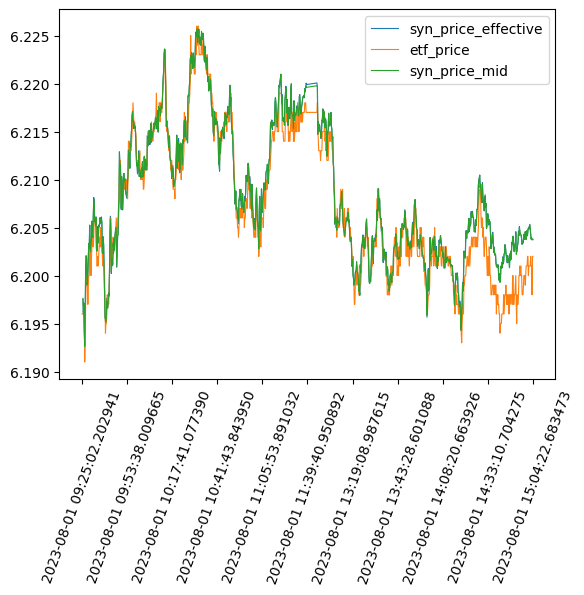

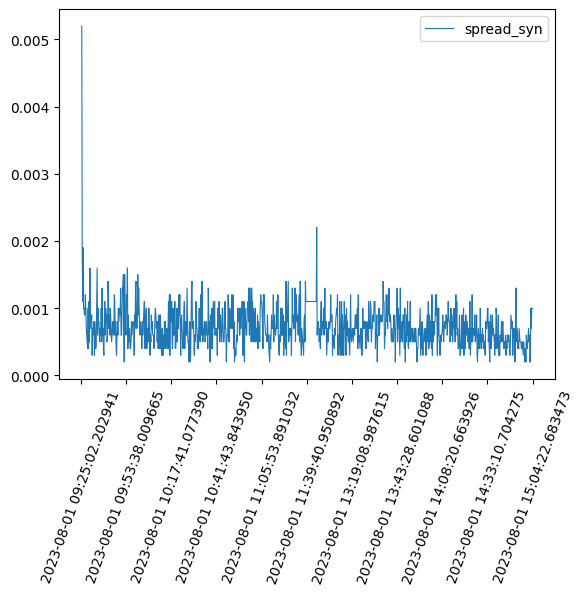

In [335]:
plot_legend_outside(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']], shrink=1000,
                    plot_uniform_timestamp=True, save_path=res_root + f"imgs/{option_symbol}_syn_price_{date_}.png")
plot_legend_outside(pcp_df['spread_syn'], shrink=1000, plot_uniform_timestamp=True,
                    save_path=res_root + f'imgs/{option_symbol}_syn_spread_{date_}.png')

In [336]:
# plot_legend_outside(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].diff(), shrink=1000, plot_uniform_timestamp=True,save_path=res_root+f"imgs/{option_symbol}_syn_price_{date_}.png")
# plot_legend_outside(pcp_df['spread_syn'].diff(), shrink=1000, plot_uniform_timestamp=True,save_path=res_root+f'imgs/{option_symbol}_syn_spread_{date_}.png')

In [338]:
# pcp_df[['spread_syn']].corrwith(pcp_df['spread_c'], method='spearman')

spread_syn    0.642158
dtype: float64

## percentage spread of option (y)

In [339]:
spread = (option_price_df['ask1'] - option_price_df['bid1']).rename('spread')
percentage_spread = (2 * (option_price_df['ask1'] - option_price_df['bid1']) / (
        option_price_df['ask1'] + option_price_df['bid1'])).rename('percentage_spread')
# spread1 = (option_price_df1['ask1'] - option_price_df1['bid1']).rename('spread')
# percentage_spread1 = (2 * (option_price_df1['ask1'] - option_price_df1['bid1']) / (
#             option_price_df1['ask1'] + option_price_df1['bid1'])).rename('percentage_spread')

In [407]:
# plot_legend_outside(spread)
# plot_legend_outside(percentage_spread)

## syn_all_mid

通过一批相同mat，不同strike的期权，计算不同strike的syn期货，然后看syn bid中最高和syn ask中最低，从而识别期货的期限套利机会，也可以用其来计算iv，可以将其作为一个因子。

pair not in file list ('10005899', '10005900')


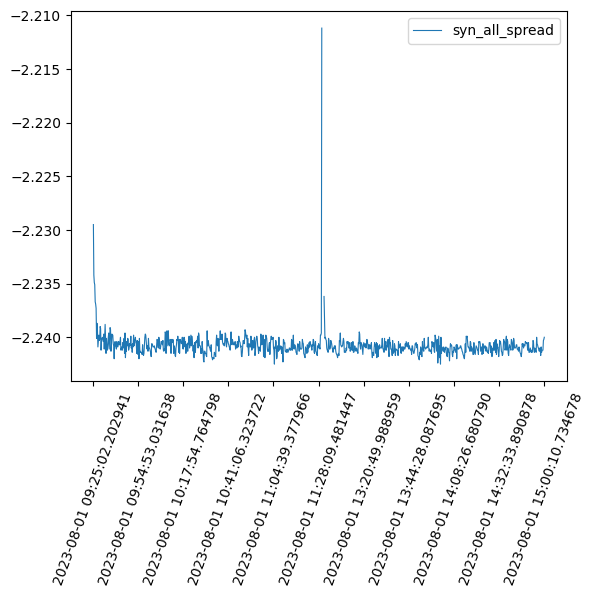

In [342]:
def calc_syn_all_spread(date_, option_info_df, expire_date, udly_symbol, etf_price_df, fe, method='cum_vol_wap',
                        level=2):
    """通过所有同mat但是不同strike的call和put去计算syn_bid and syn_ask，再分别取最大和最小值来计算每个时刻的syn_all_spread
    
    Parameters
    ----------
    date_ : 
    option_info_df : 
    expire_date : 
    udly_symbol : 
    etf_price_df : 
    fe : 
    method : 
    level : 

    Returns
    -------

    """
    idx = np.logical_and(option_info_df['expire_date'] == expire_date,
                         option_info_df['underlying_symbol'] == udly_symbol)

    syn_all_price_ask = pd.DataFrame()
    syn_all_price_bid = pd.DataFrame()
    for k, v in option_info_df.loc[idx].sort_values(['contract_type', 'exercise_price']).groupby('exercise_price',
                                                                                                 as_index=False):
        # print(v.index)
        option_symbol, option_symbol1 = v.index.values
        try:
            assert option_symbol + '.csv' in files
            assert option_symbol1 + '.csv' in files
        except AssertionError:
            print(f"pair not in file list {option_symbol, option_symbol1}")
            continue
        option_price_dict = read_option_pair_prices(date_, option_symbol, option_symbol1)
        pcp_df = synthesize_future(option_price_dict, method, level, etf_price_df, fe)[
            ['syn_price_ask', 'syn_price_bid']].rename(
            columns={'syn_price_ask': f'syn_price_ask_{k}', 'syn_price_bid': f'syn_price_bid_{k}'})
        syn_all_price_ask = pd.concat([syn_all_price_ask, pcp_df[f'syn_price_ask_{k}']], axis=1)
        syn_all_price_bid = pd.concat([syn_all_price_bid, pcp_df[f'syn_price_bid_{k}']], axis=1)

    syn_all_price_ask = syn_all_price_ask.sort_index().ffill()
    syn_all_price_bid = syn_all_price_bid.sort_index().ffill()

    syn_all_ask_min = syn_all_price_ask.min(axis=1).rename('syn_all_ask_min')
    syn_all_bid_max = syn_all_price_bid.max(axis=1).rename('syn_all_bid_max')
    syn_all_spread = (syn_all_ask_min - syn_all_bid_max).rename('syn_all_spread')
    distribution = syn_all_spread.describe()
    lower = distribution['mean'] - 2 * distribution['std']
    upper = distribution['mean'] + 2 * distribution['std']
    syn_all_spread[np.logical_or(syn_all_spread < lower, syn_all_spread > upper)] = np.nan

    return syn_all_spread


syn_all_spread = calc_syn_all_spread(date_, option_info_df, expire_date, udly_symbol, etf_price_df, fe,
                                     method='cum_vol_wap', level=2)
# plot_legend_outside(syn_all_spread)


## static factors

In [ ]:
moneyness = (pcp_df['syn_price_mid'] * np.exp(rfr * pcp_df['time2maturity']) / option_strike).rename('moneyness')
moneyness = np.log(moneyness)  # 使其分布更加正态
moneyness_squared = (moneyness ** 2).rename('moneyness_squared')
moneyness_t2m = (moneyness * pcp_df['time2maturity']).rename('moneyness_t2m')
moneyness_delta = (moneyness * iv_greeks['delta']).rename('moneyness_delta')
mid_quoted_price = ((option_price_df['ask1'] + option_price_df['bid1']) / 2).rename('mid_quoted_price')

syn_spread = pcp_df['spread_syn']
static_factors = pd.concat(
    [moneyness, moneyness_squared, moneyness_t2m, moneyness_delta, mid_quoted_price, pcp_df['time2maturity'],
     syn_spread], axis=1)
static_factors = ltp.del_untrade_time(static_factors)

## dynamic factors

In [350]:
option_price_df['volume_diff'] = option_price_df['volume'].diff()
option_price_df.loc[option_price_df.index[0], 'volume_diff'] = option_price_df['volume'].iloc[0]

window_size = 10
dynamic_factors = option_price_df['volume_diff'].loc[~(option_price_df['volume_diff'] == 0)].to_frame(
    name='avg_volume_diff')
dynamic_factors = pd.concat([dynamic_factors, calc_duration(deepcopy(dynamic_factors), name='avg_duration')], axis=1)
dynamic_factors = dynamic_factors.rolling(window_size, min_periods=1).mean()
dynamic_factors = ltp.del_untrade_time(dynamic_factors)
dynamic_factors

,avg_volume_diff,avg_duration
serverTime,,
2023-08-01 09:30:00.478367,11.000000,NaN
2023-08-01 09:30:01.008075,10.500000,0.529708
2023-08-01 09:30:01.564205,7.666667,0.542919
2023-08-01 09:30:02.694800,6.500000,0.738811
2023-08-01 09:30:06.440839,7.400000,1.490618
...,...,...
2023-08-01 14:56:45.411964,5.500000,1.800251
2023-08-01 14:56:48.908322,5.500000,2.099237
2023-08-01 14:56:49.408179,5.400000,2.050665


## cross-market factors

In [ ]:

# percentage spread of underlying asset (ETF) ETF百分比价差
etf_price_df = pd.read_csv(f"{etf_data_root}/{date_1}/{udly_symbol[:-5]}.csv", index_col='serverTime',
                           usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
etf_quoted_spread = (
        2 * (etf_price_df['ask1'] - etf_price_df['bid1']) / (etf_price_df['ask1'] + etf_price_df['bid1'])).rename(
    'etf_quoted_spread')
# plot_legend_outside(etf_quoted_spread,shrink=1000,plot_uniform_timestamp=True)
# percentage spread of index futures 股指期货百分比价差
future_price_df = pd.read_csv(f"{future_data_root}{date_1}/{etf_future_symbol_dict[udly_symbol]}{expire_date1}.csv",
                              index_col='serverTime', usecols=['serverTime', 'ask1', 'bid1'], parse_dates=True)
future_quoted_spread = (2 * (future_price_df['ask1'] - future_price_df['bid1']) / (
        future_price_df['ask1'] + future_price_df['bid1'])).rename('future_quoted_spread')
# plot_legend_outside(future_quoted_spread,shrink=1000,plot_uniform_timestamp=True)

cross_market_factors = pd.concat([etf_quoted_spread, future_quoted_spread], axis=1)
cross_market_factors.index = pd.to_datetime(cross_market_factors.index)
cross_market_factors = ltp.del_untrade_time(cross_market_factors)

## dummies

In [354]:

dummies = pd.DataFrame()
dummies['is_opening_period'] = pd.Series(is_opening_period(pcp_df.index), index=pcp_df.index, name='is_opening_period',
                                         dtype=int)

## 可解释的因子组合

In [ ]:
# 开盘不久，spread会快速下降，此时主要是time2maturity在变，因此或许该阶段time2maturity需要有较大的coef。是否可以通过dummy来构造这个
opening_decreasing = (
        np.log(1.001 - pcp_df['time2maturity'] / pcp_df['time2maturity'][0]) * dummies['is_opening_period']).rename(
    'opening_decreasing')
# plot_legend_outside(opening_decreasing, shrink=1000, plot_uniform_timestamp=True)

# 回归

In [361]:
# y_col = 'percentage_spread'
y_col = 'spread'
Xy = pd.concat(
    [iv_greeks, syn_all_spread, static_factors, dynamic_factors, cross_market_factors, dummies, opening_decreasing,
     # percentage_spread,
     spread
     ], axis=1)
Xy.index = pd.to_datetime(Xy.index)
Xy = Xy.sort_index().ffill()

In [362]:
dropna_cols = Xy.columns.tolist()
dropna_cols.remove('avg_volume_diff')
dropna_cols.remove('avg_duration')
Xy = ltp.del_untrade_time(Xy).dropna(how='any', subset=dropna_cols)
Xy = ltp.add_head_tail(Xy, date_=date_)
Xy = ltp.del_untrade_time(Xy.asfreq('3s', method='ffill')).dropna(how='any')

In [363]:
# delete outliers
Xy_mean = Xy.mean()
Xy_std = Xy.std()
idx = ((Xy - Xy_mean) / Xy_std).abs() > 3
exclude = ['delta', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'avg_duration', 'is_opening_period',
           'opening_decreasing']
idx = idx.drop(columns=exclude)
idx = idx.sum(axis=1).astype(bool)

In [364]:
pd.concat([Xy_mean - 3 * Xy_std, Xy_mean + 3 * Xy_std], axis=1)

,0,1
IV,0.130509,0.144536
delta,-0.597428,-0.514495
gamma,1.694583,1.944583
vega,0.005979,0.006480
theta,-0.001749,-0.001571
rho,-0.002439,-0.002156
syn_all_spread,-2.245218,-2.236275
moneyness,-0.008915,-0.002116
moneyness_squared,-0.000004,0.000068
moneyness_t2m,-0.000567,-0.000144


In [365]:
Xy = Xy.loc[~idx]

In [366]:
Xy.corr()

,IV,delta,gamma,vega,theta,rho,syn_all_spread,moneyness,moneyness_squared,moneyness_t2m,...,mid_quoted_price,time2maturity,spread_syn,avg_volume_diff,avg_duration,etf_quoted_spread,future_quoted_spread,is_opening_period,opening_decreasing,spread
IV,1.000000,0.684129,-0.976354,0.889907,-0.884012,-0.012433,0.215655,0.605921,-0.606106,0.546654,...,0.850200,0.879882,0.138497,0.109539,-0.245470,0.009350,-0.026657,NaN,NaN,0.159081
delta,0.684129,1.000000,-0.594086,0.838476,-0.880708,0.642567,0.037722,0.994082,-0.990104,0.981019,...,0.962943,0.596513,0.082044,0.020917,-0.081155,0.020079,-0.012544,NaN,NaN,0.130724
gamma,-0.976354,-0.594086,1.000000,-0.898051,0.772467,0.187655,-0.258313,-0.505009,0.505370,-0.433345,...,-0.787927,-0.949757,-0.169534,-0.112433,0.261233,-0.003842,0.006143,NaN,NaN,-0.172166
vega,0.889907,0.838476,-0.898051,1.000000,-0.817955,0.122247,0.207508,0.778097,-0.784262,0.719508,...,0.938516,0.936291,0.174311,0.067558,-0.192889,0.013109,0.010755,NaN,NaN,0.183656
theta,-0.884012,-0.880708,0.772467,-0.817955,1.000000,-0.449169,-0.086119,-0.844947,0.843587,-0.821134,...,-0.933698,-0.645561,-0.069619,-0.069447,0.158959,-0.019623,0.050980,NaN,NaN,-0.124154
rho,-0.012433,0.642567,0.187655,0.122247,-0.449169,1.000000,-0.221488,0.717017,-0.706557,0.775594,...,0.431532,-0.231580,-0.094927,-0.060479,0.128199,0.020541,-0.038317,NaN,NaN,-0.020672
syn_all_spread,0.215655,0.037722,-0.258313,0.207508,-0.086119,-0.221488,1.000000,0.002630,-0.011847,-0.027105,...,0.112270,0.278515,0.045981,-0.012971,-0.127996,0.087592,-0.048031,NaN,NaN,0.033254
moneyness,0.605921,0.994082,-0.505009,0.778097,-0.844947,0.717017,0.002630,1.000000,-0.994367,0.996030,...,0.929109,0.511381,0.063440,0.010045,-0.053360,0.020198,-0.011875,NaN,NaN,0.116690
moneyness_squared,-0.606106,-0.990104,0.505370,-0.784262,0.843587,-0.706557,-0.011847,-0.994367,1.000000,-0.989108,...,-0.925116,-0.516718,-0.066417,-0.004596,0.048630,-0.025322,0.014981,NaN,NaN,-0.116602
moneyness_t2m,0.546654,0.981019,-0.433345,0.719508,-0.821134,0.775594,-0.027105,0.996030,-0.989108,1.000000,...,0.895710,0.433589,0.044785,0.002917,-0.032581,0.020403,-0.014558,NaN,NaN,0.102860


In [368]:
Xy_dict.update({date_: Xy})

In [380]:
Xy = Xy_dict['2023-08-01']
# Xy=Xy_date_dict['2023-08-02']

exclude = [y_col, 'spread_syn', 'time2maturity', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'moneyness']
# _X=Xy['delta']
# _X=Xy.drop(columns=[y_col,])
_X = Xy.drop(columns=exclude)
_X = sm.add_constant(_X)
y_true = Xy[y_col]

In [381]:
model = OLS(y_true, exog=_X, missing='drop')
results = model.fit()
y_res = y_true.to_frame(name='y_true')
y_pred = model.predict(params=results.params, exog=_X)
# y_pred = model.predict(params=model_params, exog=_X)

In [382]:
print("has const", results.summary())

has const                             OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     34.09
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.12e-64
Time:                        13:38:56   Log-Likelihood:                 33869.
No. Observations:                4561   AIC:                        -6.772e+04
Df Residuals:                    4550   BIC:                        -6.765e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

/Users/hongyifan/miniconda3/envs/ML_py310/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [383]:
print("has const", ((y_true - y_pred) ** 2).sum(), ((y_true - y_pred.round(decimals=4)) ** 2).sum(),
      calc_r_squared(y_true, y_pred))

has const 9.476769463452982e-05 9.896000000000015e-05 0.06970106228735828


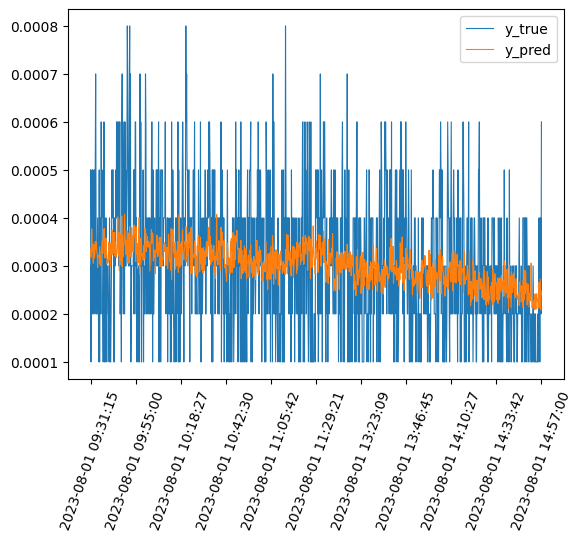

In [384]:
y_res['y_pred'] = y_pred
plot_legend_outside(y_res)

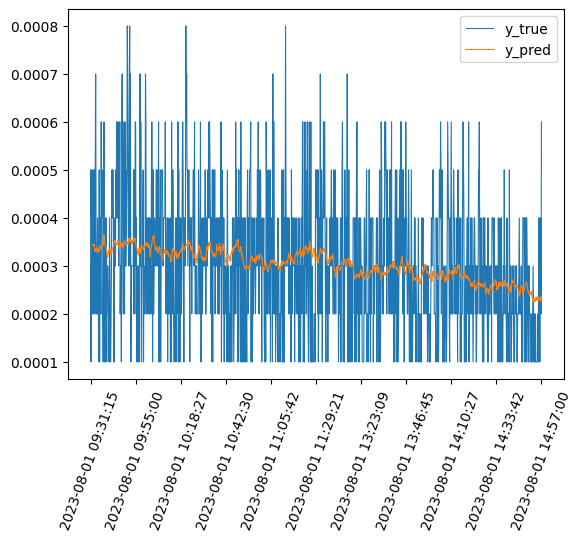

In [385]:
import talib
y_res['y_pred'] = talib.EMA(y_pred, timeperiod=20)
plot_legend_outside(y_res)

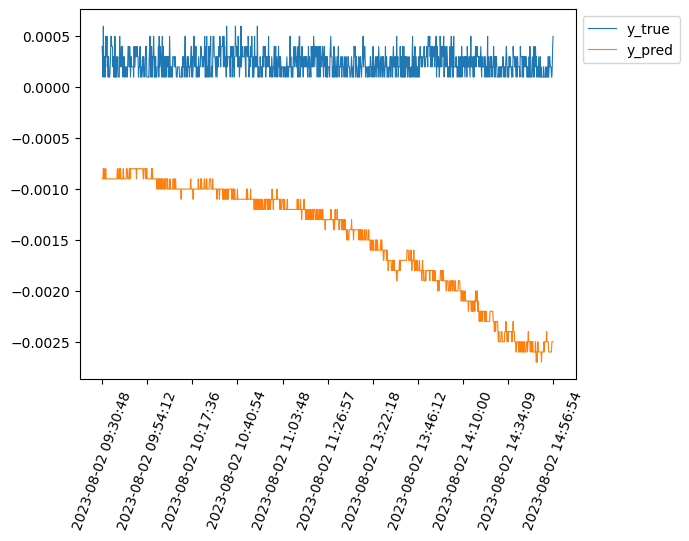

In [256]:
y_res['y_pred'] = y_pred.round(decimals=4)
plot_legend_outside(y_res)

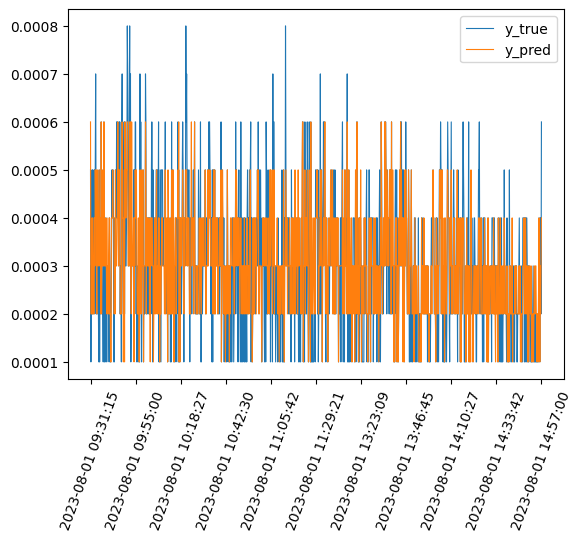

In [183]:
y_res['y_pred'] = y_pred.round(decimals=4)
plot_legend_outside(y_res)

# 结果统计


## Distribution

In [49]:
percentage_spread.describe()

count    28332.000000
mean         0.004357
std          0.002413
min          0.001220
25%          0.002747
50%          0.004199
75%          0.005808
max          0.048000
Name: percentage_spread, dtype: float64

## spread min or max?

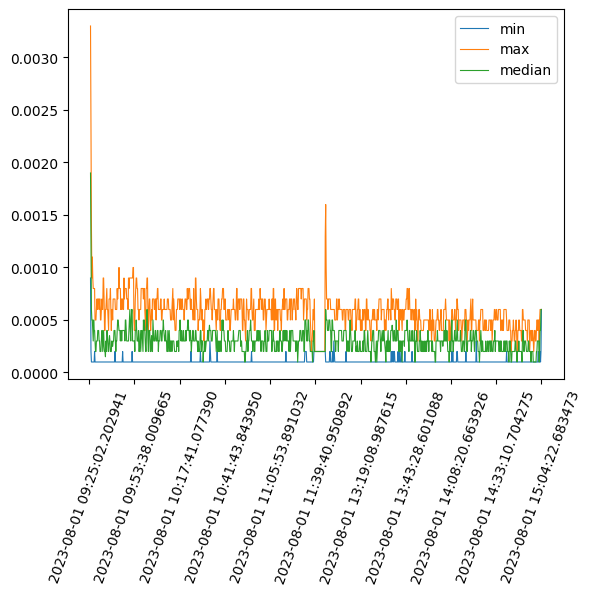

In [50]:
plot_legend_outside(pcp_df['spread_c'].rolling(100).agg(['min', 'max', 'median']), shrink=1000,
                    plot_uniform_timestamp=True)

## spread - correlation

spearman 能识别非线性相关性，pearson对异常值较为敏感

In [51]:
# spread 和 syn_price_mid的diff 有着较高的相关性
method = 'spearman'
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].diff().corrwith(pcp_df['spread_syn'].diff(),
                                                                                    method=method))
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].diff().corrwith(pcp_df['spread_c'].diff(),
                                                                                    method=method))
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].diff().corrwith(pcp_df['spread_p'].diff(),
                                                                                    method=method))

syn_price_effective    0.006175
etf_price             -0.000904
syn_price_mid          0.015333
dtype: float64
syn_price_effective    0.006837
etf_price             -0.000043
syn_price_mid          0.013136
dtype: float64
syn_price_effective    0.000403
etf_price             -0.000044
syn_price_mid          0.004648
dtype: float64


In [52]:
# etf价格有着较强的相关性
method = 'spearman'
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].corrwith(pcp_df['spread_syn'], method=method))
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].corrwith(pcp_df['spread_c'], method=method))
print(pcp_df[['syn_price_effective', 'etf_price', 'syn_price_mid']].corrwith(pcp_df['spread_p'], method=method))

syn_price_effective    0.094645
etf_price              0.131652
syn_price_mid          0.094481
dtype: float64
syn_price_effective    0.050367
etf_price              0.082952
syn_price_mid          0.051129
dtype: float64
syn_price_effective    0.045903
etf_price              0.072085
syn_price_mid          0.045469
dtype: float64


In [53]:
# syn的spread有着很强的相关性
# method='pearson'
method = 'spearman'
pcp_df[['spread_syn', 'spread_c', 'spread_p']].corr(method=method)

,spread_syn,spread_c,spread_p
spread_syn,1.000000,0.642158,0.826311
spread_c,0.642158,1.000000,0.166286
spread_p,0.826311,0.166286,1.000000


## spread - iv

猜想：
- 只有当iv到达一定阈值时才会有较大的spread

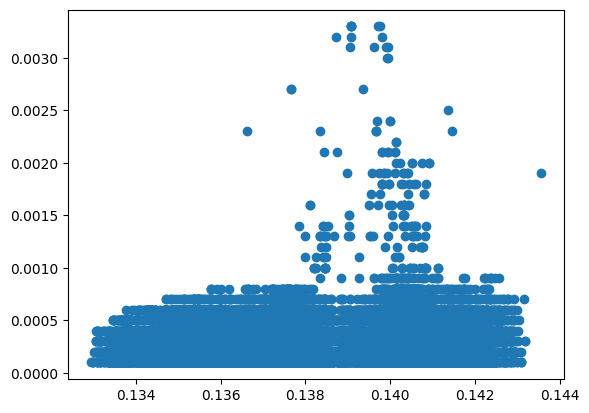

In [54]:
plt.scatter(x=iv_greeks['IV'], y=pcp_df['spread_c'])

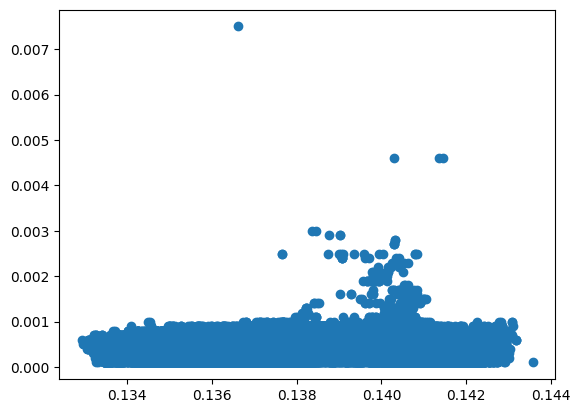

In [55]:
plt.scatter(x=iv_greeks['IV'], y=pcp_df['spread_p'])

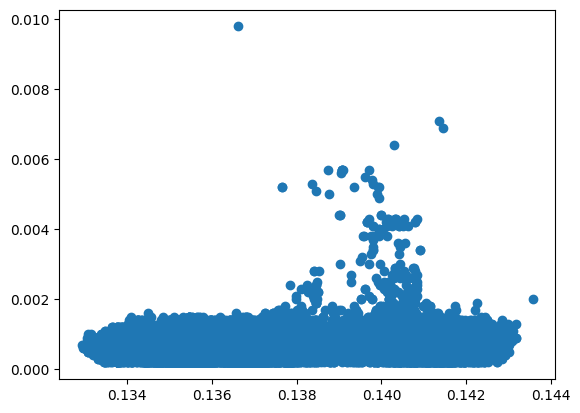

In [56]:
plt.scatter(x=iv_greeks['IV'], y=pcp_df['spread_syn'])

# 计算


# 保存

In [265]:
if not os.path.exists(model_root):
    os.mkdir(model_root)
with open(model_root + f"{get_class_name(results)}_{'2023-08-01'}.pkl", 'wb') as fw:
    pickle.dump(results, fw)

In [229]:
model_params = results.params